Guides referenced in the completion of this section:<br>
https://www.tensorflow.org/tutorials/generative/dcgan<br>
https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

In [1]:
import os

# Suppress tensorflow logging:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow CUDA {"is" if tf.test.is_built_with_cuda() else "is not"} available.')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('Tensorflow set GPU memory growth to True.')
    except RuntimeError as e:
        print(e)
print(f'Tensorflow {"is" if tf.executing_eagerly() else "is not"} executing eagerly.')

from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display
import imageio
import time

dark1 = '#191b26'
dark2 = '#151722'
white1 = '#fff'
white2 = '#b3b5be'
red1 = '#cd6152'
red2 = '#cd6152'
green1 = '#67a39a'
green2 = '#253037'
blue1 = '#4a64fd'
blue2 = '#1b1f39'

mpl.rcParams['text.color'] = white2
mpl.rcParams['axes.labelcolor'] = white2
mpl.rcParams['axes.facecolor'] = dark1
mpl.rcParams['axes.edgecolor'] = white2
mpl.rcParams['figure.facecolor'] = dark2
mpl.rcParams['xtick.color'] = white2
mpl.rcParams['ytick.color'] = white2
mpl.rcParams['axes.spines.right'] = False

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markeredgewidth'] = 3
mpl.rcParams['lines.markersize'] = 10

mpl.rcParams['patch.linewidth'] = 3
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.dpi'] = 96
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['patch.antialiased'] = True

Tensorflow version: 2.5.0
Tensorflow CUDA is available.
Tensorflow set GPU memory growth to True.
Tensorflow is executing eagerly.


In [5]:
# Define constants.
BATCH_SIZE = 64
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

GRAPH_INTERVAL = 25
PRINT_INTERVAL = 5

EPOCHS = 999
LINEAR_SIZE = 4*4*128       # Size of Dense layer in Generator.
LATENT_DIMS = 100           # Number of random numbers to use at Generator input.
NUM_GENERATED_SAMPLES = 8   # Number of sample fake images to generate to visualise training.

# This set of latent inputs will be used for each training graph output,
# so we can visualise progress on the same latent samples.
SEED = tf.random.normal([NUM_GENERATED_SAMPLES, LATENT_DIMS])

Set up dataset pipeline. Resize each image, and remap RGB values to [-1,1].

In [6]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory('C:\img_align_celeba',
                                                                     labels=None,
                                                                     label_mode=None,
                                                                     image_size=IMAGE_SIZE,
                                                                     smart_resize=True,
                                                                     shuffle=True,
                                                                     batch_size=BATCH_SIZE)

# Rescale all [0,255] images to [-1,1], as our generator outputs with tanh.
image_dataset = image_dataset.map(lambda x: Rescaling(scale=1./127.5, offset=-1)(x))

Found 202599 files belonging to 1 classes.


Display sample image from dataset

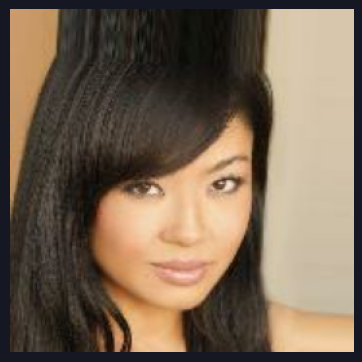

In [7]:
def normalize(array, min, max, type):
    """Scale array values to [min, max]"""
    array = array.reshape((-1,))
    array = np.interp(array, (array.min(), array.max()), (min, max))
    image = array.reshape((IMAGE_WIDTH,IMAGE_HEIGHT,3))
    return image.astype(int) if type is int else image.astype(float)


img = image_dataset.take(1)
img = np.array(list(img.as_numpy_iterator())).reshape((BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# model = Sequential()
# model.add(Rescaling(scale=1./127.5, offset=-1))
# model.compile()
#
# y = model(img, training=False)
# y = y.numpy()

plt.axis('off')
plt.tight_layout()
plt.imshow(normalize(img[0], 0, 255, int))
plt.show()

Set up generator and discrimator.
Display sample fake image from generator (untrained).
Display sample prediction from discriminator (untrained).

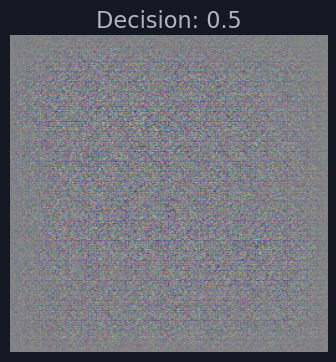

In [8]:
def make_generator_model():
    init = RandomNormal(stddev=0.02)

    model = Sequential()

    model.add(Dense(LINEAR_SIZE, use_bias=False, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,128)))
    assert model.output_shape == (None, 4,4,128)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', kernel_initializer=init))
    assert model.output_shape == (None, 8,8, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', kernel_initializer=init))
    assert model.output_shape == (None, 16,16, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', kernel_initializer=init))
    assert model.output_shape == (None, 32,32, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', kernel_initializer=init))
    assert model.output_shape == (None, 64,64, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', kernel_initializer=init))
    assert model.output_shape == (None, 128,128, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init,
                                     activation='tanh'))
    assert model.output_shape == (None, IMAGE_WIDTH, IMAGE_HEIGHT, 3)

    return model


def make_discriminator_model():
    init = RandomNormal(stddev=0.02)

    model = Sequential()

    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init,
                            input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


def generate_latent_coordinates(batches, dimensions):
    return tf.random.normal([batches, dimensions])

generator = make_generator_model()
discriminator = make_discriminator_model()

# Demonstrate generator and discriminator on 1 random noise sample.
generated_image = generator(generate_latent_coordinates(1, LATENT_DIMS), training=False)
decision = discriminator(generated_image)
img = normalize(generated_image.numpy(), 0, 1, float)
plt.title(f'Decision: {decision[0][0]}')
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()


def disc_loss(real_output, fake_output):
    """
    How well the discriminator can distinguish real from fake images.
    :param real_output: Classifications of real images.
    :param fake_output: Classifications of fake images.
    :return: Loss on real images, loss on fake images.
    """
    # Compare predictions on real images to array of ones.
    real_loss = BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    # Compare predictions on fake images to array of zeroes.
    fake_loss = BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    return real_loss, fake_loss


def gen_loss(fake_output):
    """
    How well the generator can fool the discriminator.
    We get this loss from the discriminator, and pass it to the generator.
    :param fake_output: Discriminator classification of fake images.
    :return: Loss of discriminator on fake images, inverted.
    """
    # Compare discriminator decisions to array of ones.
    return BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)


gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

checkpoint_dir = 'C:/Pred_Models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

KeyboardInterrupt: 

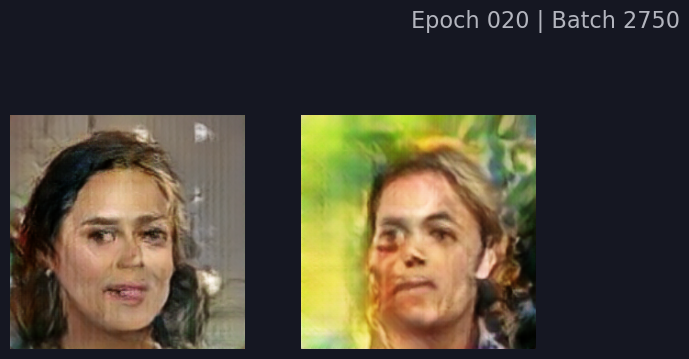

In [9]:
def plot_gan_progress(g_losses, d_real_losses, d_fake_losses, model, epoch, batch, test_input):
    """
    Plot tensorflow train and validation metrics and loss in one chart.
    :param history: Dictionary containing the accuracy and loss history.
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(15, 11))
    fig.suptitle(f'Epoch {epoch:03} | Batch {batch:03}')

    for i in range(predictions.shape[0]):
        plt.subplot(3, 4, i + 1)
        plt.axis('off')
        plt.imshow(normalize(predictions[i].numpy(), 0, 255, int).astype(int))

    plt.subplot(3, 4, (9,12))
    plt.title(f'GAN generator and discriminator losses')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    if len(g_losses) > 50:
        plt.plot(g_losses[len(g_losses)-50:], c=green1, label=f'gen loss')
        plt.plot(d_real_losses[len(d_real_losses)-50:], c='purple', label=f'disc real loss')
        plt.plot(d_fake_losses[len(d_fake_losses)-50:], c='#ff884d', label=f'disc fake loss')
    else:
        plt.plot(g_losses, c=green1, label=f'gen loss')
        plt.plot(d_real_losses, c='purple', label=f'disc real loss')
        plt.plot(d_fake_losses, c='#ff884d', label=f'disc fake loss')
    plt.tight_layout()
    plt.legend(loc='upper left')

    plt.savefig(f'C:/Pred_Images/preds_at_epoch{epoch:04}_batch{batch:04}.png')
    plt.show()


@tf.function
def train_step(images):
    """
    Conduct forward and backward pass, updating weights of each model
    by their loss.
    :param images: Batch of images (either real or fake)
    :return: Losses, for plotting only.
    """
    # Random latent space input for generator.
    noise = generate_latent_coordinates(BATCH_SIZE, LATENT_DIMS)

    # Track gradients of each model.
    # ie. Track what happened in what order during forward pass.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Forward pass.
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        g_loss = gen_loss(fake_output)
        d_real_loss, d_fake_loss = disc_loss(real_output, fake_output)
        d_loss = d_real_loss + d_fake_loss

    # Backward pass.
    # Calculate gradient for each models trainable weights.
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    # Update generator and discriminator weights with gradients.
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_real_loss, d_fake_loss


def train(dataset, epochs):
    g_losses, d_real_losses, d_fake_losses = [], [], []
    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(dataset):
            # Start training step, tracking losses.
            g_loss, d_real_loss, d_fake_loss = train_step(image_batch)
            g_loss, d_real_loss, d_fake_loss = g_loss.numpy(), d_real_loss.numpy(), d_fake_loss.numpy()

            # Update output graph every n batches.
            if i % GRAPH_INTERVAL == 0:
                g_losses.append(g_loss)
                d_real_losses.append(d_real_loss)
                d_fake_losses.append(d_fake_loss)
                display.clear_output(wait=True)
                plot_gan_progress(g_losses, d_real_losses, d_fake_losses, generator, epoch, i, SEED)
            if i % PRINT_INTERVAL == 0:
                print(f'Epoch {epoch:04}: batch {i:04}/{len(dataset)} | g_loss: {g_loss} | '
                      f'd_fake_loss: {d_fake_loss} | d_real_loss: {d_real_loss}', end='\r')

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))


train(image_dataset, EPOCHS)



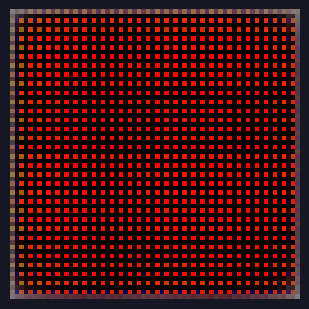

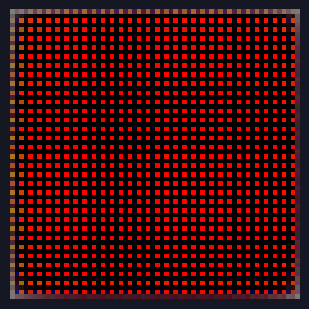

In [13]:
checkpoint_dir = 'C:/Pred_Models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore("C:/Pred_models/ckpt-16.index")

predictions = generator(generate_latent_coordinates(1, 100), training=False)
plt.axis('off')
plt.imshow(normalize(predictions[0].numpy(), 0, 255, int).astype(int))
plt.show()

predictions = generator(generate_latent_coordinates(1, 100), training=False)
plt.axis('off')
plt.imshow(normalize(predictions[0].numpy(), 0, 255, int).astype(int))
plt.show()